<a href="https://colab.research.google.com/github/17520299/DS102.L11.CNCL/blob/main/Detectron2-12/15-PredictFromModelTrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [4]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


In [5]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [6]:
!wget https://www.dropbox.com/s/vzr55y4lqx7te2b/Dataset.zip
!unzip Dataset.zip

--2020-12-16 14:45:31--  https://www.dropbox.com/s/vzr55y4lqx7te2b/Dataset.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/vzr55y4lqx7te2b/Dataset.zip [following]
--2020-12-16 14:45:31--  https://www.dropbox.com/s/raw/vzr55y4lqx7te2b/Dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbc775694934c76f558e65b9ac6.dl.dropboxusercontent.com/cd/0/inline/BFJkgi1VYoBSl4JhsAoZ4Q4YFxpV9sABdSH-0N_DgGFPEI9gSs-pknaqiBlEBINqQOstQDx1WVZ6y6xMgbgQBEUmlk0qKC-WGKCuPvLl2dI9eIKWlNMzQxOZXOcL7ivh3cI/file# [following]
--2020-12-16 14:45:31--  https://ucbc775694934c76f558e65b9ac6.dl.dropboxusercontent.com/cd/0/inline/BFJkgi1VYoBSl4JhsAoZ4Q4YFxpV9sABdSH-0N_DgGFPEI9gSs-pknaqiBlEBINqQOstQDx1WVZ6y6xMgbgQBEUmlk0qKC-WGKCuPvLl2dI9eIKWlN

In [7]:
import json
from detectron2.structures import BoxMode
def get_traffic_dicts(imgdir):
  json_file = imgdir+'/data.json'
  with open(json_file) as f:
    dataset_dicts = json.load(f)
  for i in dataset_dicts:
    filename=i['file_name']
    i['file_name'] = imgdir+"/"+filename
    for j in i['annotations']:
      j['bbox_mode'] = BoxMode.XYWH_ABS
      j['category_id'] = int(j['category_id'])
  return dataset_dicts
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ['Train','Test']:
  DatasetCatalog.register('traffic_'+d,lambda d=d: get_traffic_dicts('/content/Dataset/'+d))
  MetadataCatalog.get('traffic_'+d).set(thing_classes=['pedestrian','car','van','bus','truck','motor','bicycle','tricycle','other'])
traffic_metadata = MetadataCatalog.get('traffic_Train')

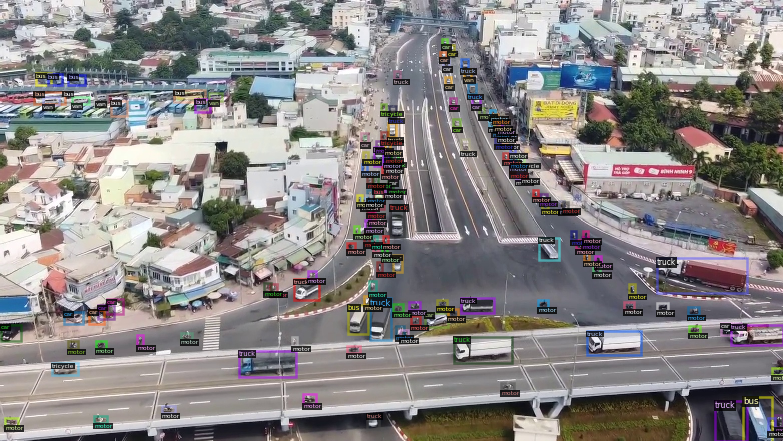

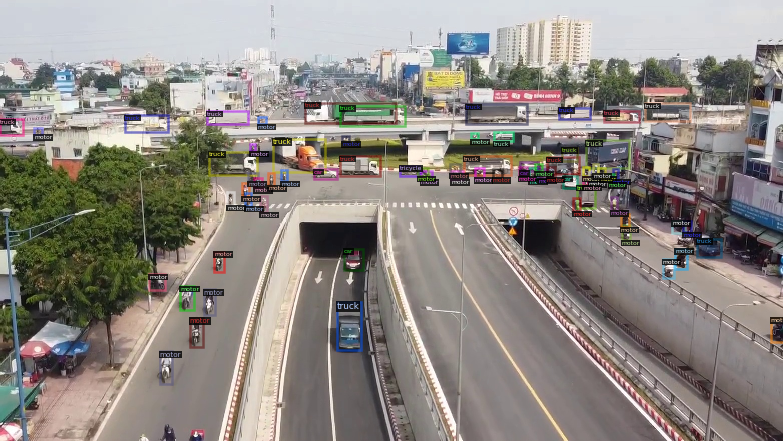

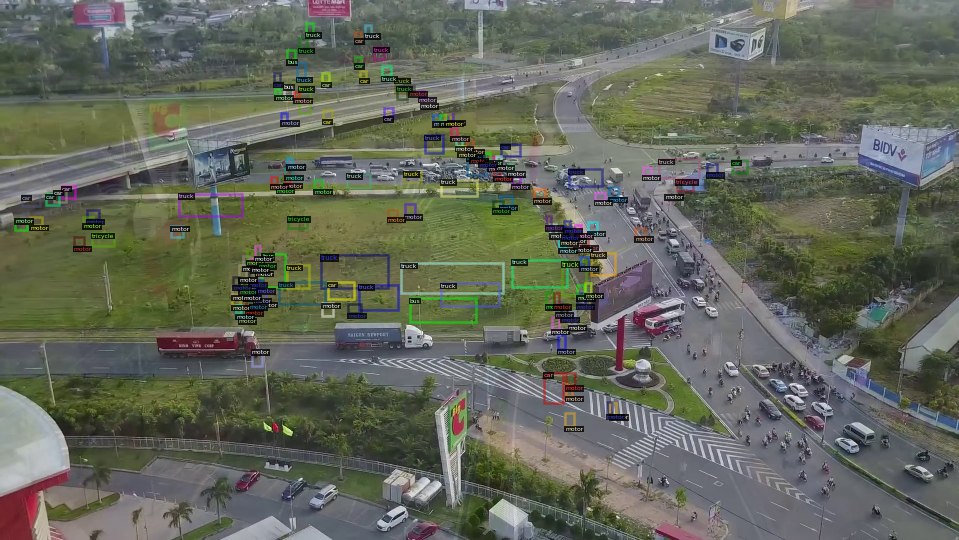

In [8]:
dataset_dicts = get_traffic_dicts('/content/Dataset/Train/')
for d in random.sample(dataset_dicts,3):
  img = cv2.imread(d['file_name'])
  visualizer = Visualizer(img[ :, :, ::-1], metadata=traffic_metadata,scale=0.5)
  vis = visualizer.draw_dataset_dict(d)
  cv2_imshow(vis.get_image()[:,:,::-1])

In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

!wget https://www.dropbox.com/s/w56o9qr17a7kifn/model_C4%281021%29.pth

--2020-12-16 14:46:53--  https://www.dropbox.com/s/w56o9qr17a7kifn/model_C4%281021%29.pth
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/w56o9qr17a7kifn/model_C4%281021%29.pth [following]
--2020-12-16 14:46:53--  https://www.dropbox.com/s/raw/w56o9qr17a7kifn/model_C4%281021%29.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc44b826315f23732324c110a71d.dl.dropboxusercontent.com/cd/0/inline/BFIY172q3DrSJq8DOwCAQYfR4dWU3FVl5MoEfRHfu9ADQt3RA6r7L1lTFfHtKzjtJd39hlbSLtA03lyczt7YKRsDNG8t7bHz3uiKtPVaQY59LsEX50oEDAG19NneyHOgxXw/file# [following]
--2020-12-16 14:46:54--  https://uc44b826315f23732324c110a71d.dl.dropboxusercontent.com/cd/0/inline/BFIY172q3DrSJq8DOwCAQYfR4dWU3FVl5MoEfRHfu9ADQt3RA6r7L1lTFfHtKzjtJd39hlbSLtA03lycz

In [11]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml"))
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9
cfg.MODEL.WEIGHTS = os.path.join('/content', "model_C4(1021).pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("traffic_Test", )

predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


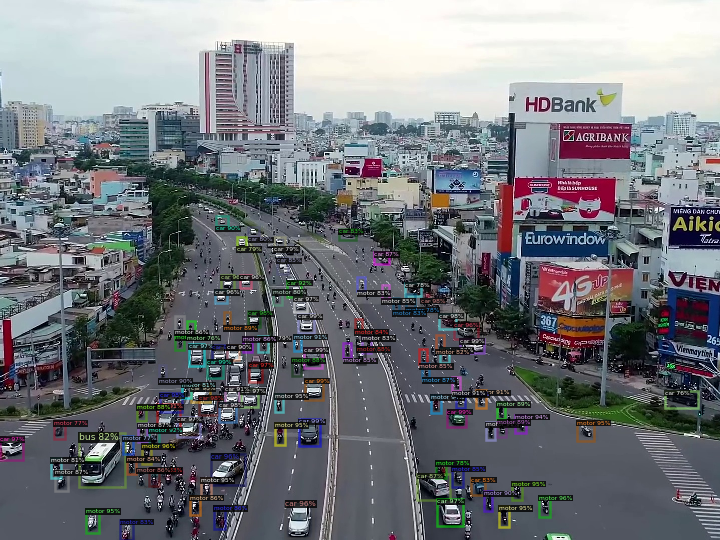

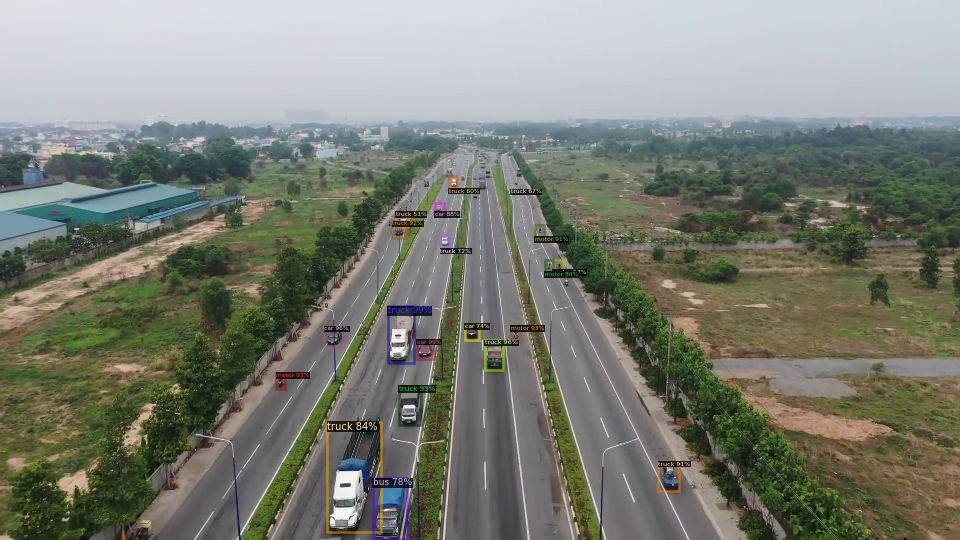

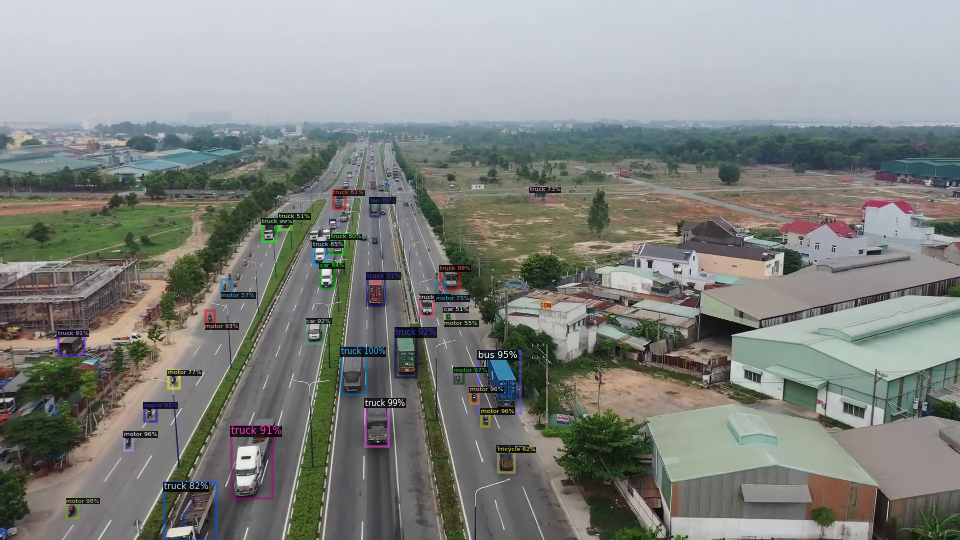

In [12]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_traffic_dicts("/content/Dataset/Test")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=traffic_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("traffic_Test", cfg, False, output_dir="/output/")
test_loader = build_detection_test_loader(cfg, "traffic_Test")
inference_on_dataset(predictor.model, test_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [12/16 15:06:10 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass tasks in directly
[12/16 15:06:10 d2.evaluation.coco_evaluation]: 'traffic_Test' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[12/16 15:06:10 d2.data.datasets.coco]: Converting annotations of dataset 'traffic_Test' to COCO format ...)
[12/16 15:06:10 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[12/16 15:06:12 d2.data.datasets.coco]: Conversion finished, #images: 327, #annotations: 23749
[12/16 15:06:12 d2.data.datasets.coco]: Caching COCO format annotations at '/output/traffic_Test_coco_format.json' ...
[12/16 15:06:12 d2.data.build]: Distribution of instances among all 9 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| pedestrian | 103     

In [ ]:
from google.colab import files
files.download('/content/output/model_final.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>